In [1]:
import pickle
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import shap
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import r2_score
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 
/home/user/conda/envs/recsys/lib/python3.9/site-packages/numba/core/config.py:154: RuntimeWarning: environ NUMBA_NUM_THREADS defined but failed to parse ''
  warnings.warn("environ %s defined but failed to parse '%s'" %

libgomp: Invalid value for environment variable OMP_NUM_THREADS
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
X = pd.read_csv(os.path.join("notebooks", "feature_importance", "data.csv"), index_col=False)

In [4]:
X = X[X.columns.difference(['FracInteractionsVal', 'FracInteractionsTest',
       'FracPassiveUsersVal', 'FracPassiveUsersTest', 'FracPassiveItemsVal',
       'FracPassiveItemsTest',])]

In [5]:
# Split by dataset_name to ensure entire groups are in train or test, not split between them
train_datasets, test_datasets = train_test_split(X['Dataset'].unique(), test_size=0.1, random_state=142)

train_df = X[X['Dataset'].isin(train_datasets)]
test_df = X[X['Dataset'].isin(test_datasets)]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sasrec
R-squared (R2) Score: -0.3929643249601871


[17:41:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


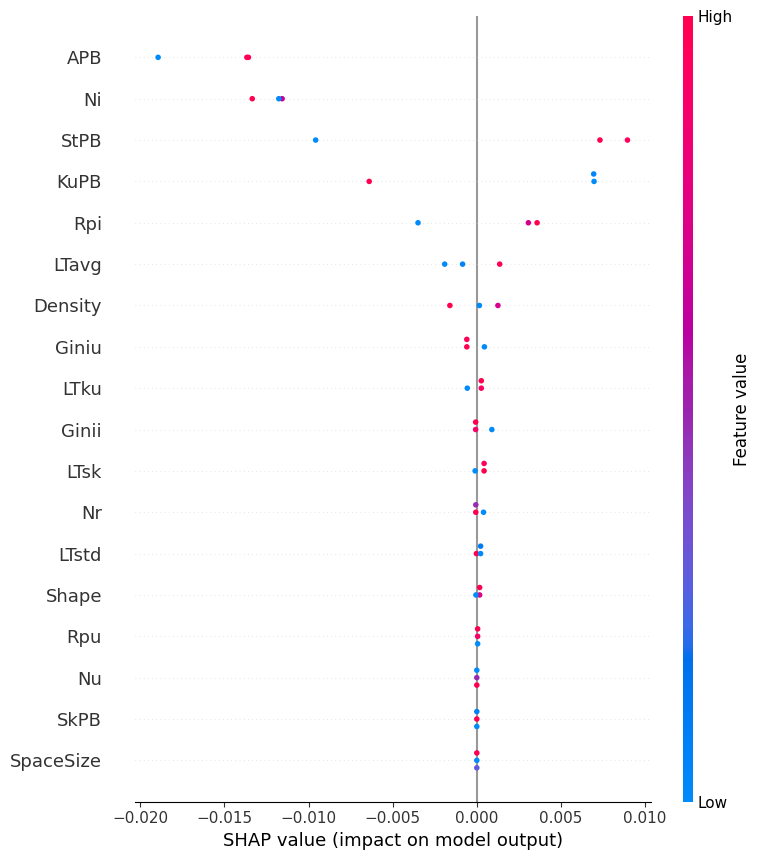

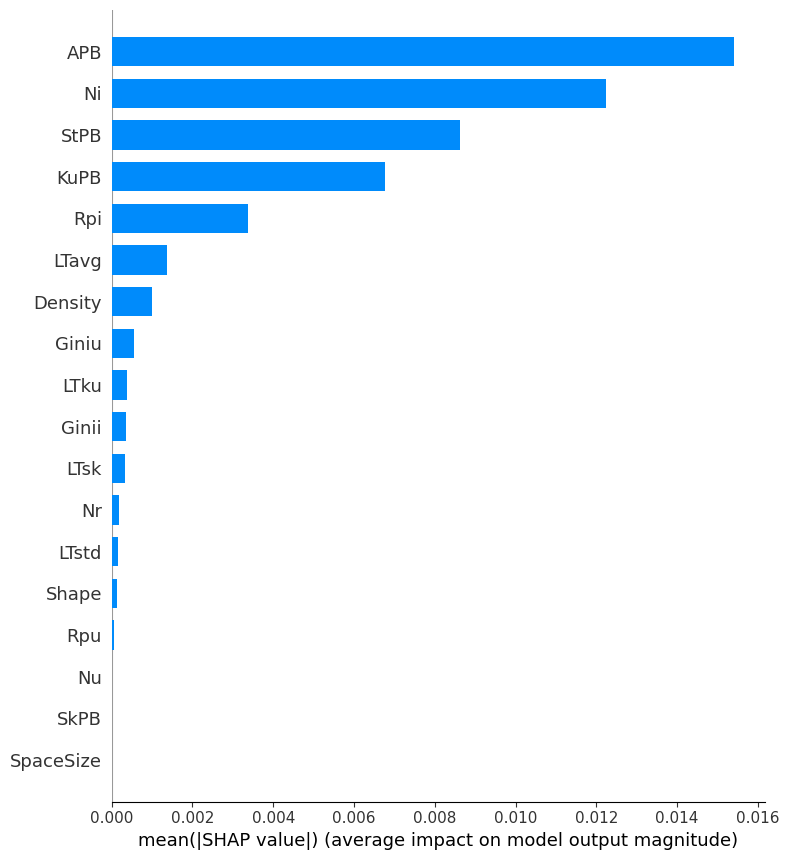

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
recbole_ItemKNN
R-squared (R2) Score: -43.267703458394244


[17:41:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


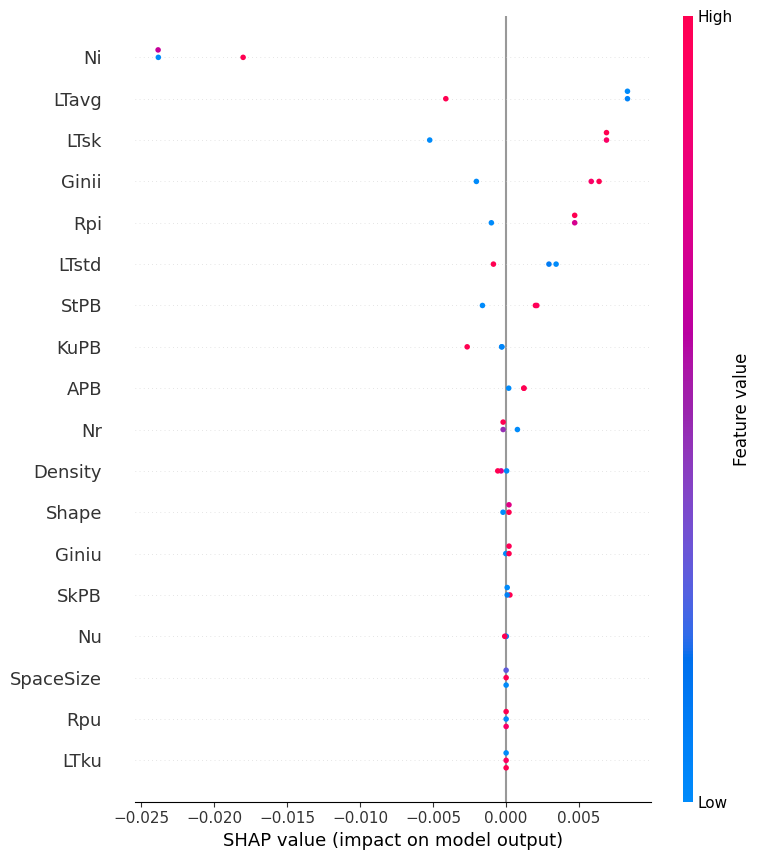

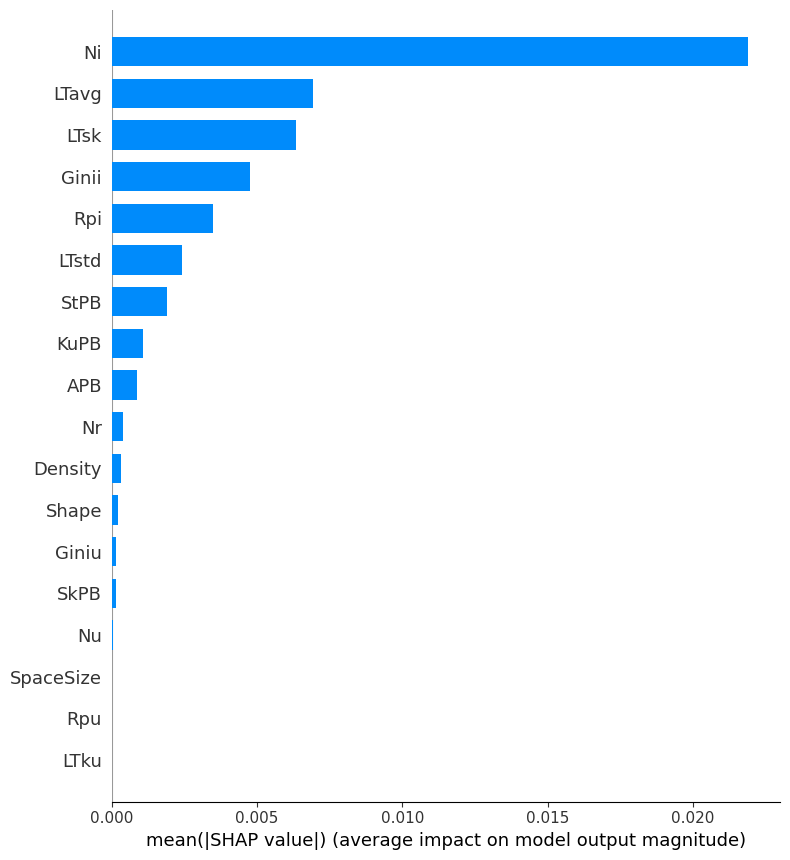

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
recbole_EASE
R-squared (R2) Score: -1123.850933256487


[17:41:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


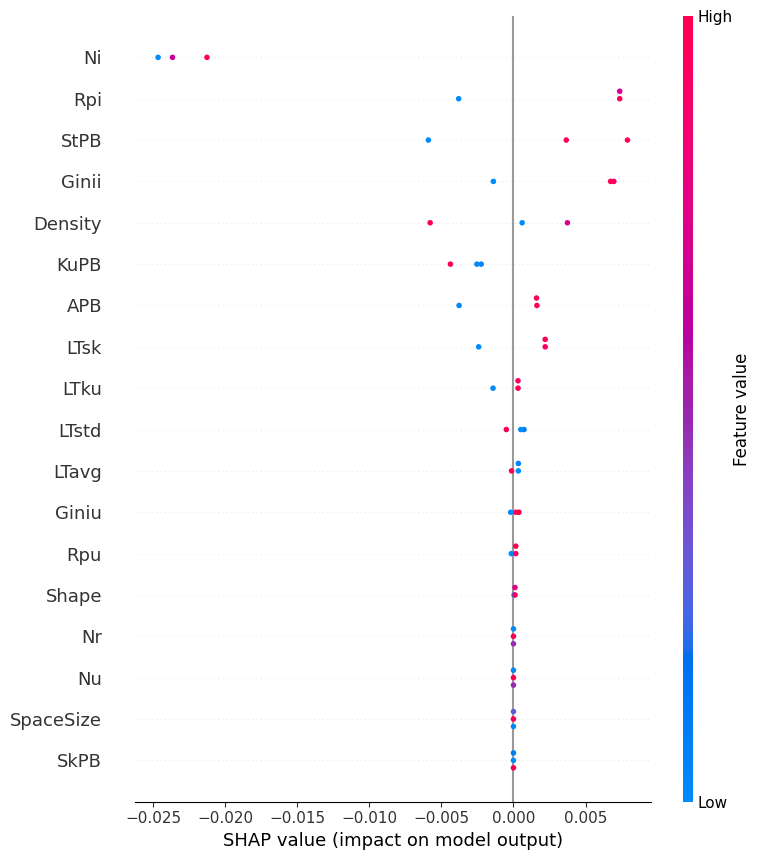

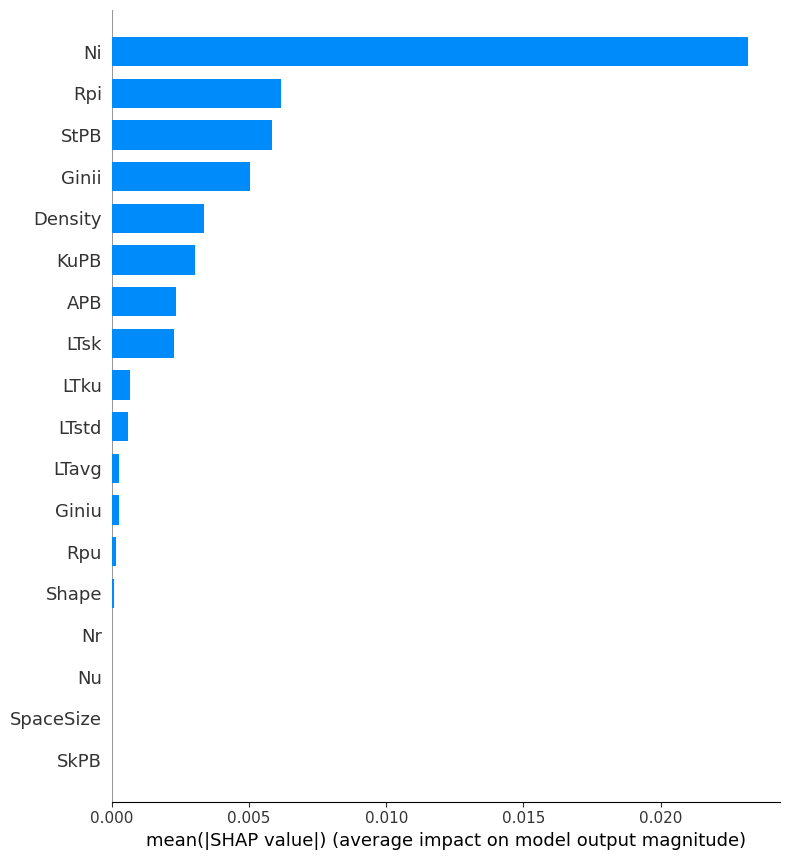

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
recbole_MultiVAE
R-squared (R2) Score: -68.92487458764326


[17:41:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


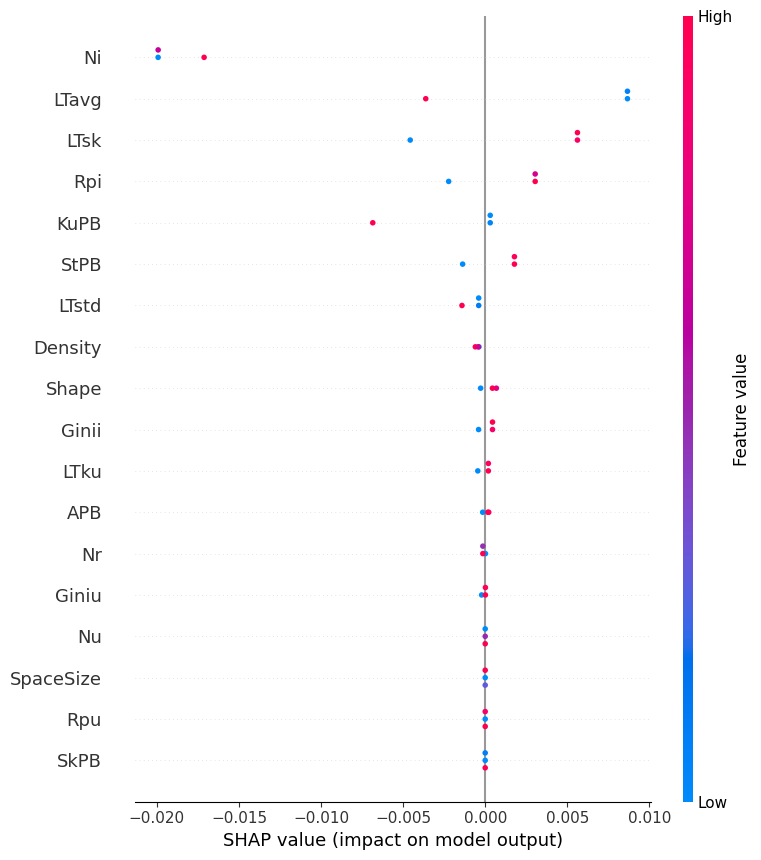

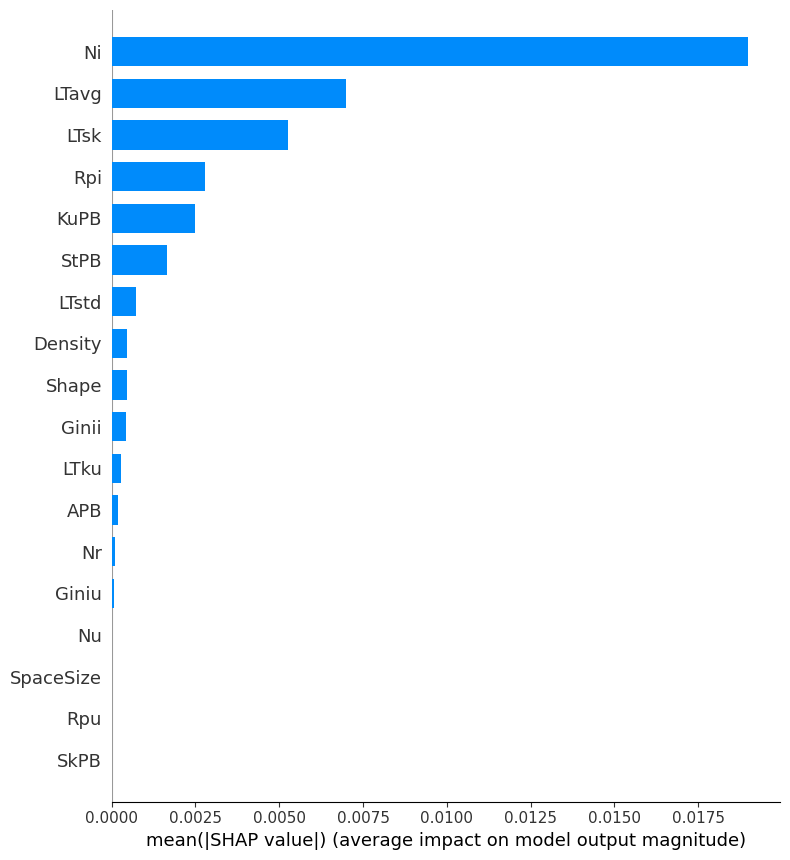

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
implicit_bpr
R-squared (R2) Score: -0.9730786467826036


[17:41:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


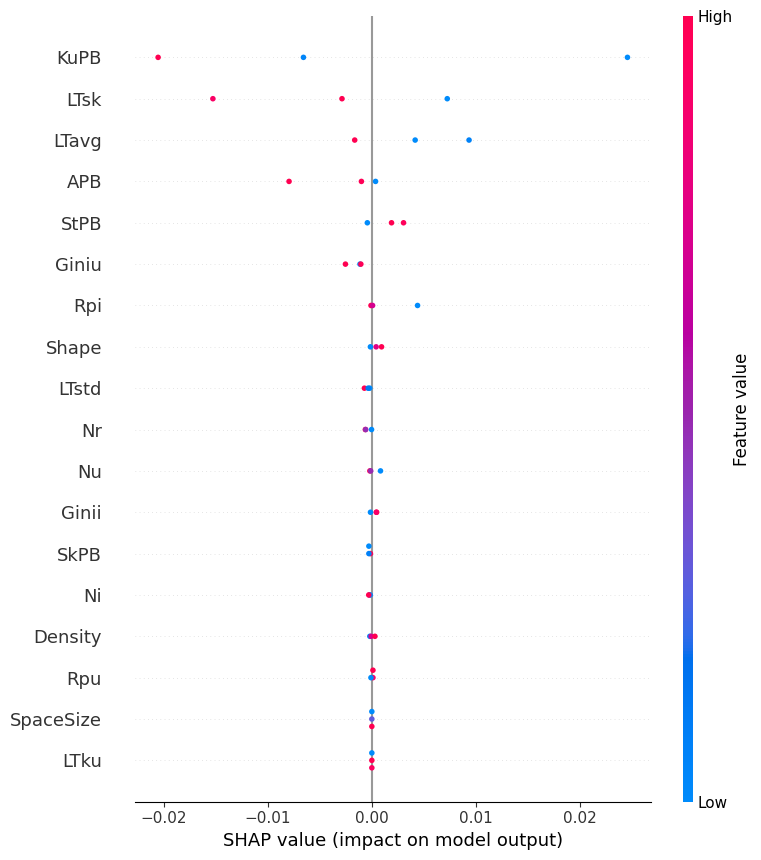

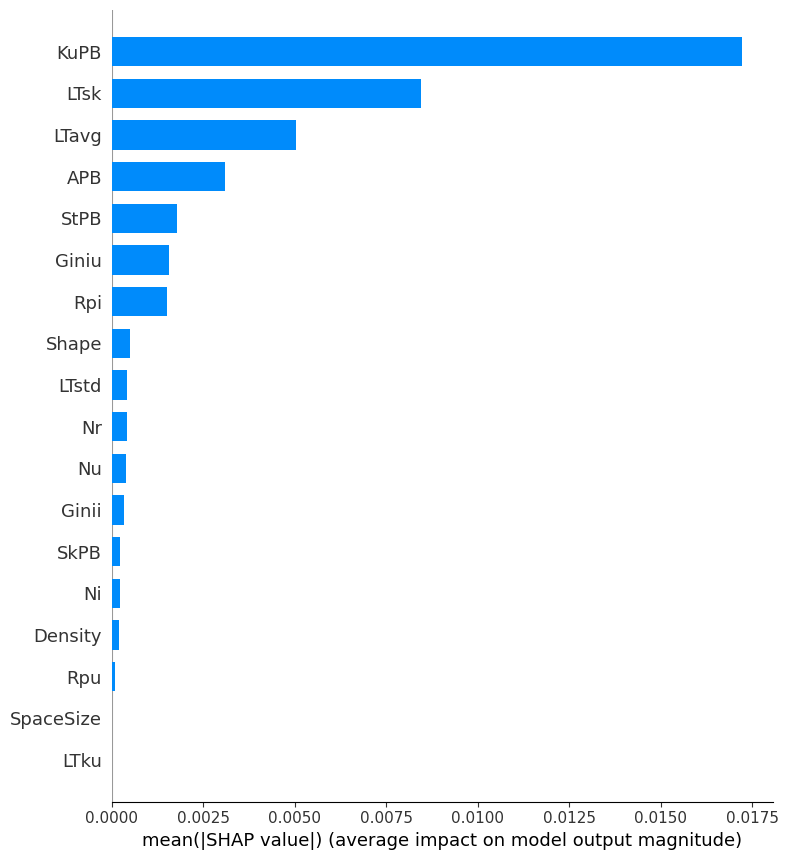

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
implicit_als
R-squared (R2) Score: -1.1971284180474568


[17:42:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


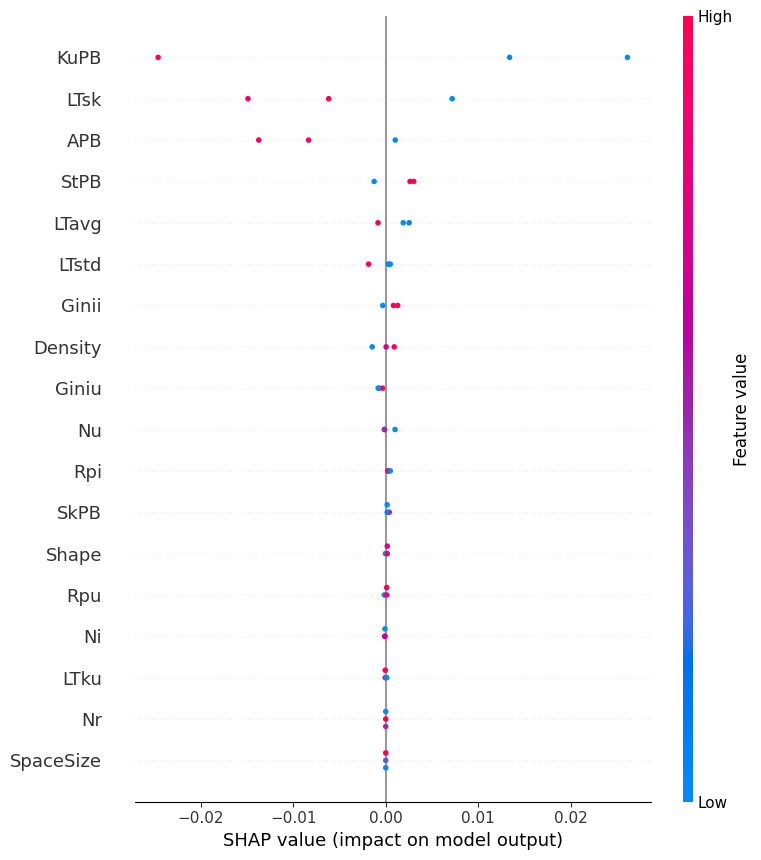

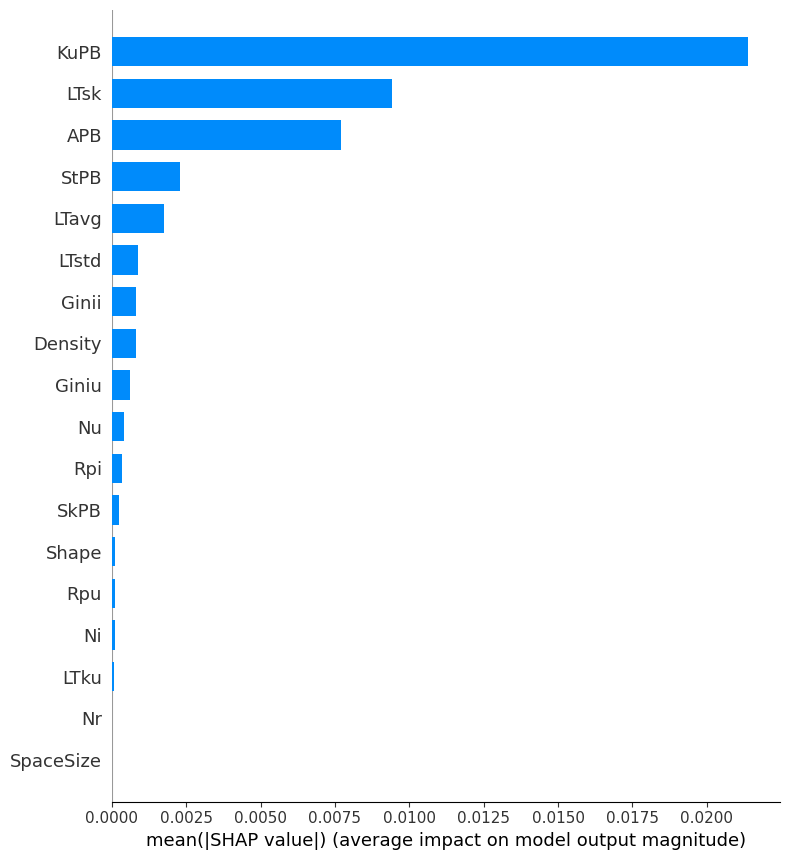

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lightfm
R-squared (R2) Score: -229.28965939808538


[17:42:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


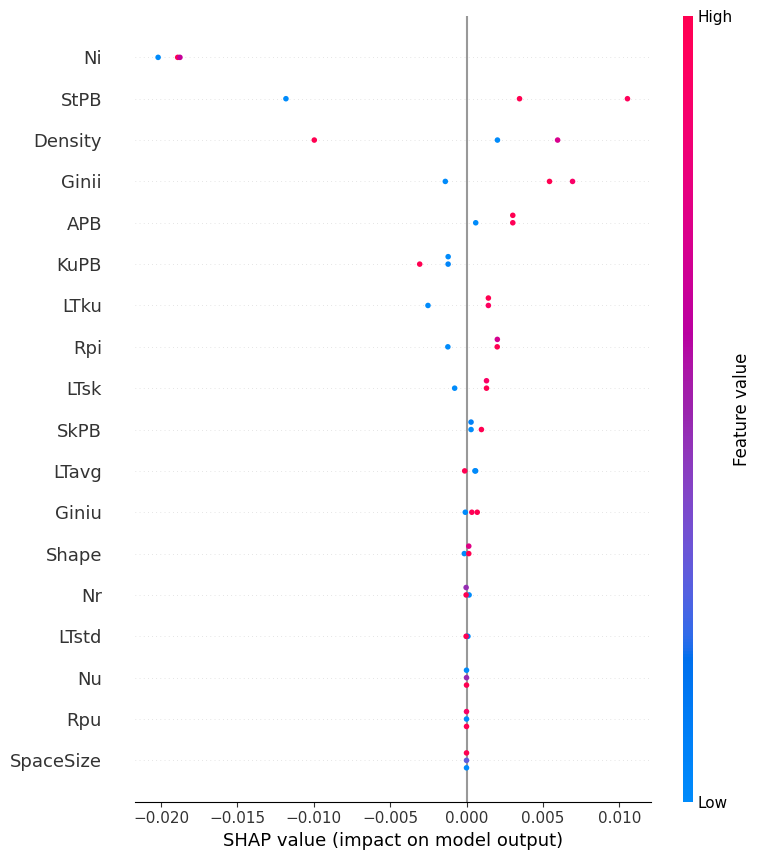

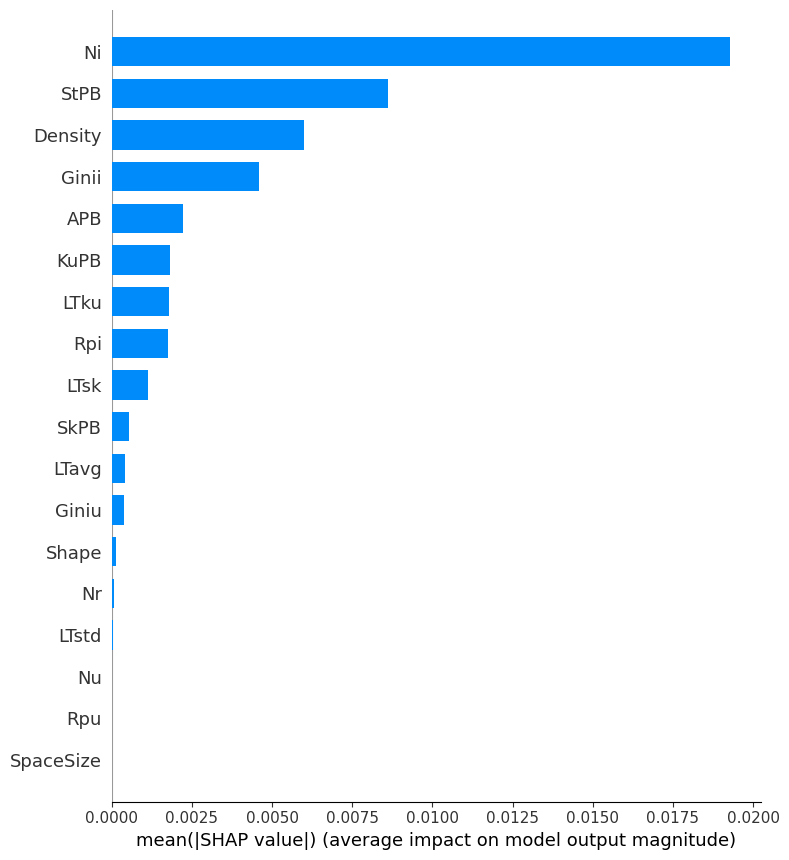

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
for model in X.Method.unique():
    X_train = train_df[train_df['Method']==model][train_df.columns.difference(['Dataset', 'Method', 'Value',])]
    y_train = train_df[train_df['Method']==model]['Value'].values

    X_test = test_df[test_df['Method']==model][test_df.columns.difference(['Dataset', 'Method', 'Value',])]
    y_test = test_df[test_df['Method']==model]['Value'].values
    
    print('--'*100)
    print(model)
    
    # Train an XGBoost regressor
    model = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)

    # Calculate the R2 score
    r2 = r2_score(y_test, y_pred)
    print("R-squared (R2) Score:", r2)
    
    # Use SHAP to interpret the model
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    
    # mean_shap_values = np.abs(shap_values.values).mean(axis=0)
    # feature_importance = pd.Series(mean_shap_values, index=X_test.columns).sort_values(ascending=False)
    # print(feature_importance)
    shap.summary_plot(shap_values, X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    print('--'*100)

In [6]:
def train_and_get_feature_importance(X_train, y_train):
    # Train an XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_train)
    
    # Calculate the R2 score for this split
    r2 = r2_score(y_pred, y_train)

    # Use SHAP to interpret the model
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    
    # Calculate and store mean SHAP values as feature importances
    mean_shap_values = np.abs(shap_values.values).mean(axis=0)
    return pd.Series(mean_shap_values, index=X_train.columns), r2

In [7]:
results_list = []
columns_to_drop = ['Dataset', 'Method', 'Value']
r2_dict = dict()
for model in X.Method.unique():
    feature_importance_model_list = []
    r2_model_list = []
    print('--'*100)
    print(model)
    for random_state in range(5):
        train_datasets_rand, _ = train_test_split(X['Dataset'].unique(), test_size=0.3, random_state=random_state)
        train_df_rand = X[X['Dataset'].isin(train_datasets_rand)]
        X_train_rand = train_df_rand.drop(columns=columns_to_drop).astype(float)
        y_train_rand = train_df_rand['Value']
        
        feature_importance, r2 = train_and_get_feature_importance(X_train_rand, y_train_rand)
        feature_importance_model_list.append(feature_importance)
        r2_model_list.append(r2)
        
    # Calculate mean and std of feature importance
    mean_feature_importance = pd.DataFrame(feature_importance_model_list).mean()
    std_feature_importance = pd.DataFrame(feature_importance_model_list).std()

    r2_dict[model] = np.mean(r2_model_list)
    
    # Combine mean and std into a single DataFrame  
    result_df_model = pd.concat([mean_feature_importance, std_feature_importance], axis=1)
    result_df_model.columns = ['Mean Feature Importance', 'Std Feature Importance']
    results_list.append(result_df_model)
    print('--'*100)

# # Sort the values by mean feature importance
result_df = pd.concat(results_list, axis=0) 
result_df = result_df.groupby(result_df.index).mean()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sasrec


[11:18:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:18:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:19:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:19:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:20:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
recbole_ItemKNN


[11:20:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:20:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:21:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:21:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:21:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
recbole_EASE


[11:22:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:22:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:23:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:23:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:23:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
recbole_MultiVAE


[11:24:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:24:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:25:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:25:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:25:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
implicit_bpr


[11:26:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:26:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:26:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:27:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:27:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
implicit_als


[11:28:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:28:29] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:28:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:29:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:29:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lightfm


[11:29:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:30:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:30:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:31:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


[11:31:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [8]:
result_df

,Mean Feature Importance,Std Feature Importance
APB,0.026743,0.013805
Density,0.001463,0.002013
Ginii,0.002272,0.002685
Giniu,0.000499,0.000649
KuPB,0.008431,0.006855
LTavg,0.000020,0.000022
LTku,0.000111,0.000104
LTsk,0.000237,0.000296
LTstd,0.000078,0.000160
Ni,0.005358,0.010666


In [9]:
r2_dict

{'sasrec': 0.3719548118961059,
 'recbole_ItemKNN': 0.3719548118961059,
 'recbole_EASE': 0.3719548118961059,
 'recbole_MultiVAE': 0.3719548118961059,
 'implicit_bpr': 0.3719548118961059,
 'implicit_als': 0.3719548118961059,
 'lightfm': 0.3719548118961059}

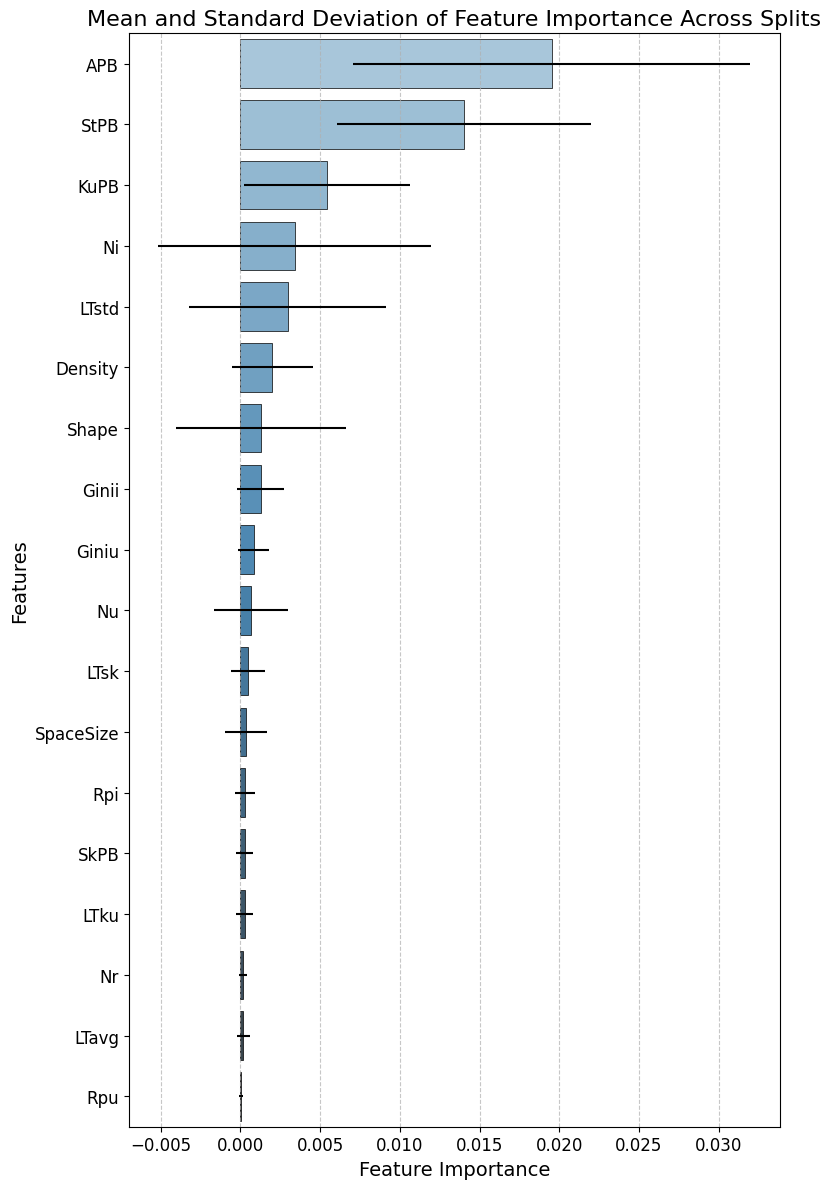

In [26]:
# Sort by Mean Feature Importance
result_df = result_df.sort_values(by='Mean Feature Importance', ascending=False)
# Plot
plt.figure(figsize=(8, 12))
# Barplot with modified aesthetics
sns.barplot(y=result_df.index, x=result_df['Mean Feature Importance'], xerr=result_df['Std Feature Importance'],
            orient='h', palette="Blues_d", edgecolor="k", linewidth=0.5, errwidth=1.2, capsize=0.3)

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Title and labels
plt.title('Mean and Standard Deviation of Feature Importance Across Splits', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Tight layout and display
plt.tight_layout()
plt.show()